In [12]:
import json
import math
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [18]:
results_dir = os.path.join("results")
images_dir = os.path.join("images")
os.makedirs(images_dir, exist_ok=True)
sns.set_context("paper") 

In [19]:
totals = {
    "nils": 14856,
    "entities_found": 71500,
    "entities_not_found": 23528,
    "generic_types": 96,
    "specific_types": 774,
    "acronyms": 3518,
    "typos": 12135,
    "alias": 7117,
    "single_domain": 435,
    "multi_domain": 435,
    "small_per_cols": 152,
    "medium_per_cols": 465,
    "large_per_cols": 253,
    "small_per_rows": 394,
    "medium_per_rows": 232,
    "large_per_rows": 244,
    "total_tables": 870,
    "total_rows": 37820,
    "total_cols": 5252,
    "total_cells": 133137,
}
totals = pd.DataFrame.from_dict(
    totals, orient="index", columns=["challenge_total"]
).reset_index(names="challenge")
print(totals)

             challenge  challenge_total
0                 nils            14856
1       entities_found            71500
2   entities_not_found            23528
3        generic_types               96
4       specific_types              774
5             acronyms             3518
6                typos            12135
7                alias             7117
8        single_domain              435
9         multi_domain              435
10      small_per_cols              152
11     medium_per_cols              465
12      large_per_cols              253
13      small_per_rows              394
14     medium_per_rows              232
15      large_per_rows              244
16        total_tables              870
17          total_rows            37820
18          total_cols             5252
19         total_cells           133137


In [20]:
def fix_model_name(model_name: str) -> str:
    if model_name == "meta-llama-3.1-8b-it":
        model_name = "Llama-3.1-8b-it"
    if model_name == "mistral-large-it":
        model_name = "Mistral-Large-123b-it"
    elif model_name.lower() == "tablellama":
        model_name = "TableLlama-7b"
    elif "Phi-3-mini".lower() in model_name.lower():
        model_name = model_name.replace("-it", "-3.8b-it")
    elif "Phi-3-small".lower() in model_name.lower():
        model_name = model_name.replace("-it", "-7b-it")
    elif "gemma" in model_name.lower():
        model_name = model_name.replace("gemma", "Gemma")
    if "llama" in model_name.lower():
        model_name = model_name.replace("llama", "Llama")
    return model_name

In [21]:
overall_results = []
per_challenge_results = []
overall_columns = ["model_name", "total_time", "accuracy", "total_correct", "ne_cells"]
columns_to_exlude = ["system", "machine", "processor", "cuda"]

for filename in os.listdir(results_dir):
    if filename.endswith(".json") and not filename.startswith("annotable_prompts"):
        print(filename)
        data = json.load(open(os.path.join(results_dir, filename)))
        data.pop("final_stats")
        for k, v in data.pop("stats").items():
            if k in {"alias", "typos", "acronyms"}:
                continue
            data[k] = v
        data["model_name"] = re.sub(
            "instruct", "it", data["model_name"].split("/")[-1], flags=re.IGNORECASE
        )
        data["model_name"] = fix_model_name(data["model_name"])
        data.pop("errors", None)

        data = pd.DataFrame.from_dict(data, orient="index").T
        data = data.melt(id_vars=["model_name"])

        overall_data = (
            data[data["variable"].isin(overall_columns)]
            .pivot(columns="variable", values="value", index="model_name")
            .reset_index()
        )
        overall_results.append(overall_data)

        data = data[~data["variable"].isin(overall_columns + columns_to_exlude)]
        data = data.rename(columns={"variable": "challenge", "value": "correct"})
        try:
            data["total"] = data.apply(
                lambda x: totals[totals["challenge"] == x["challenge"]][
                    "challenge_total"
                ].values[0],
                axis=1,
            )
        except Exception:
            print(filename)
        data["accuracy"] = data["correct"] / (
            data["total"] if "total" in data.columns else data["total_correct"]
        )
        per_challenge_results.append(data)

overall_results = pd.concat(overall_results, ignore_index=True).reset_index()
per_challenge_results = pd.concat(
    per_challenge_results, ignore_index=True
).reset_index()

Llama-3.2-1B.json
Llama-3.2-3B.json
Yi-1.5-6B.json
Phi-3-mini-4k-instruct.json
Qwen2.5-7B.json
Qwen2.5-0.5B.json
Falcon3-7B-Instruct.json
Qwen2-1.5B.json
Phi-3-small-8k-instruct.json
Yi-1.5-9B.json
mistral-large-instruct.json
Phi-3-mini-128k-instruct.json
llama-3.3-70b-instruct.json
Qwen2-7B.json
Qwen2-0.5B.json
gemma-2-2b-it.json
gemma-2-9b-it.json
TableLlama.json
meta-llama-3.1-8b-instruct.json


In [22]:
overall_results.sort_values(by=["accuracy"], ascending=[True], inplace=True)

In [23]:
# Define base colors for each model family
model_families = {
    "Qwen": "#3366CC",  # Blue family
    "Llama": "#DC3912",  # Red family
    "Phi": "#109618",  # Green family
    "Yi": "#FF9900",  # Orange family
    "gemma": "#990099",  # Purple family
    "Falcon": "#0099C6",  # Teal family
    "meta": "#DD4477",  # Pink family
    "mistral": "#66AA00",  # Lime family
}

# Identify all models in each family
family_models = {}
for model in overall_results["model_name"]:
    for family in model_families:
        if family.lower() in model.lower():
            if family not in family_models:
                family_models[family] = []
            family_models[family].append(model)
            break

# Create a palette mapping each model to its color
palette = {}
for family, models in family_models.items():
    # Sort models by accuracy within each family
    sorted_models = sorted(
        models,
        key=lambda x: overall_results[overall_results["model_name"] == x][
            "accuracy"
        ].values[0],
    )
    # Create different brightness levels based on accuracy ranking
    shades = sns.light_palette(model_families[family], n_colors=len(models) + 2)[1:-1]
    # Assign each model a shade
    for i, model in enumerate(sorted_models):
        palette[model] = shades[i]

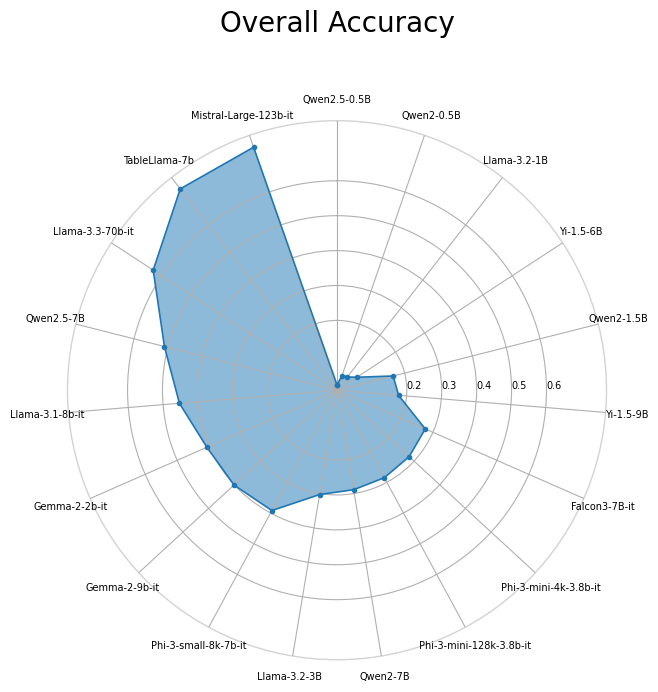

In [24]:
def plot_radar_chart(data, metrics, title):
    N = len(data)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    theta = np.concatenate([theta, [theta[0]]])

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "polar"})
    ax.set_title(title, y=1.15, fontsize=20)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(90)
    ax.spines["polar"].set_zorder(1)
    ax.spines["polar"].set_color("lightgrey")

    # color_palette = ["#339F00", "#0500FF", "#9CDADB", "#FF00DE", "#FF9900", "#FFFFFF"]

    values = data[metrics].values.flatten().tolist()
    values = values + [values[0]]
    ax.plot(theta, values, marker="o", markersize=3)
    ax.fill(theta, values, alpha=0.50)

    plt.xticks(
        theta[:-1],
        data["model_name"].tolist(),
        color="black",
        size=7,
    )
    plt.yticks(
        [0.2, 0.3, 0.4, 0.5, 0.6],
        ["0.2", "0.3", "0.4", "0.5", "0.6"],
        color="black",
        size=7,
    )
    return fig


# Plot
fig = plot_radar_chart(overall_results, ["accuracy"], title="Overall Accuracy")
plt.show()

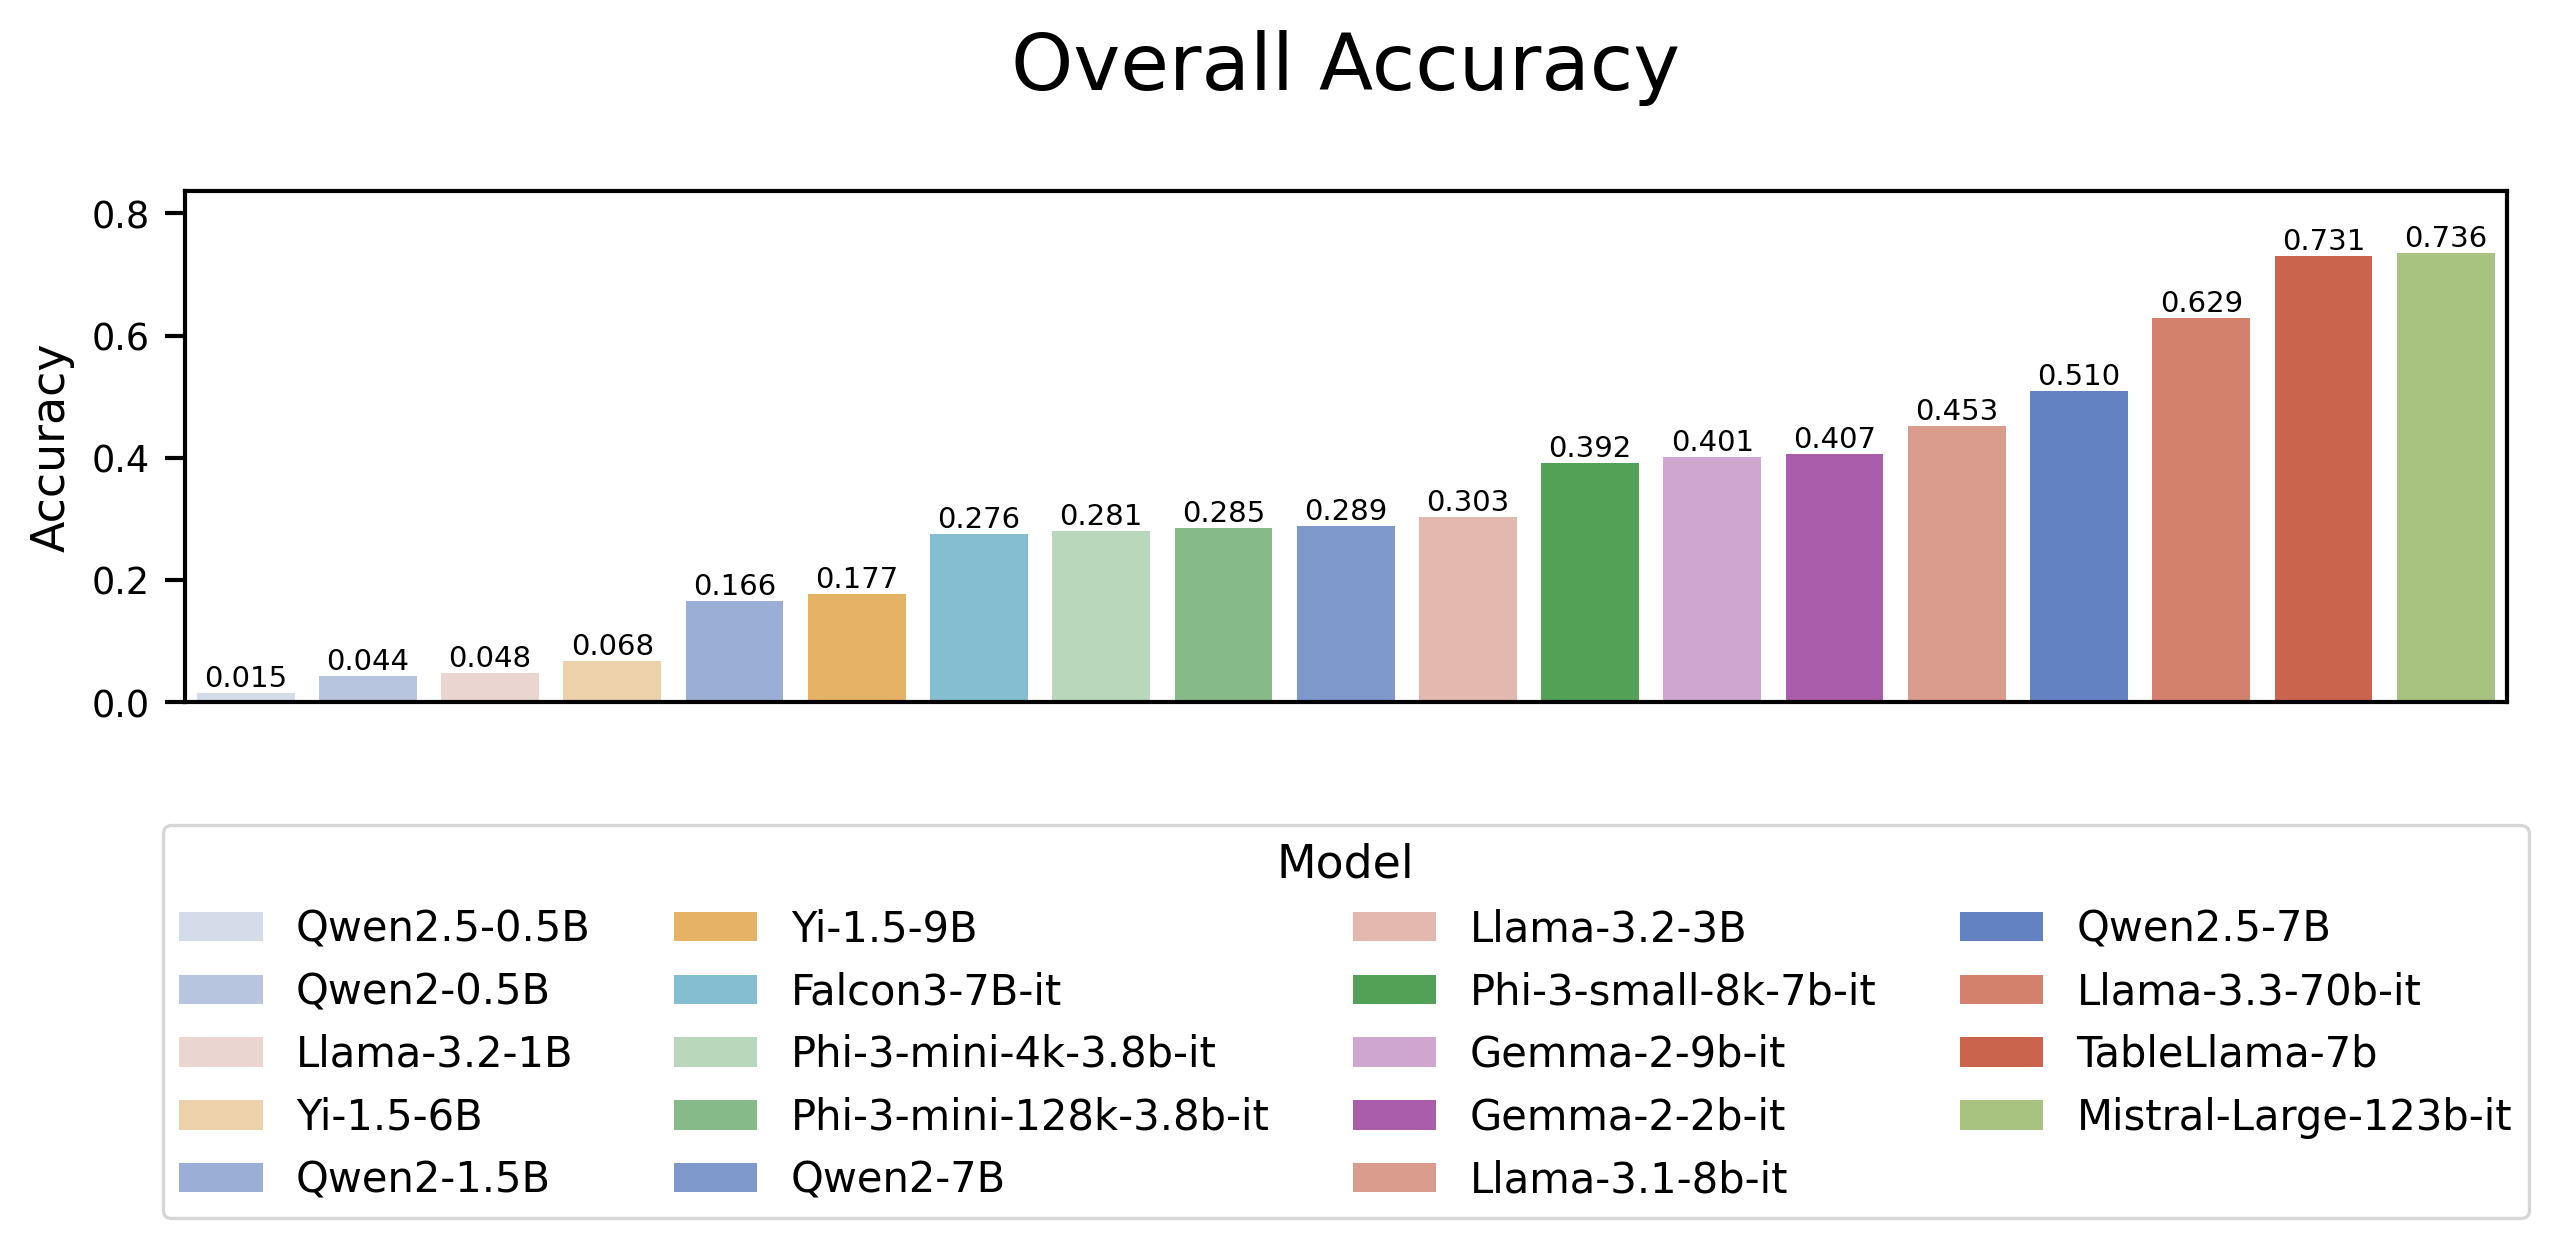

In [25]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=300)
ax.set_title("Overall Accuracy", y=1.15, fontsize=19)
ax.set_ylabel("Accuracy", fontsize=11)
plt.ylim(0, overall_results["accuracy"].max() + 0.1)
bars = sns.barplot(
    overall_results,
    x="model_name",
    y="accuracy",
    hue=overall_results["model_name"],
    palette=palette,
    legend=True,
    ax=ax,
)
plt.xlabel("")
plt.xticks(ticks=[])

for p in bars.containers:
    p = p.patches[0]
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        fontsize=7,
    )
sns.move_legend(
    ax,
    "upper center",
    bbox_to_anchor=(0.5, -0.2),
    title="Model",
    fontsize=10,
    title_fontsize=11,
    ncols=4,
)
plt.tight_layout()
plt.savefig(
    os.path.join(images_dir, "overall_accuracy.png"),
    bbox_inches="tight",
    dpi=300,
)

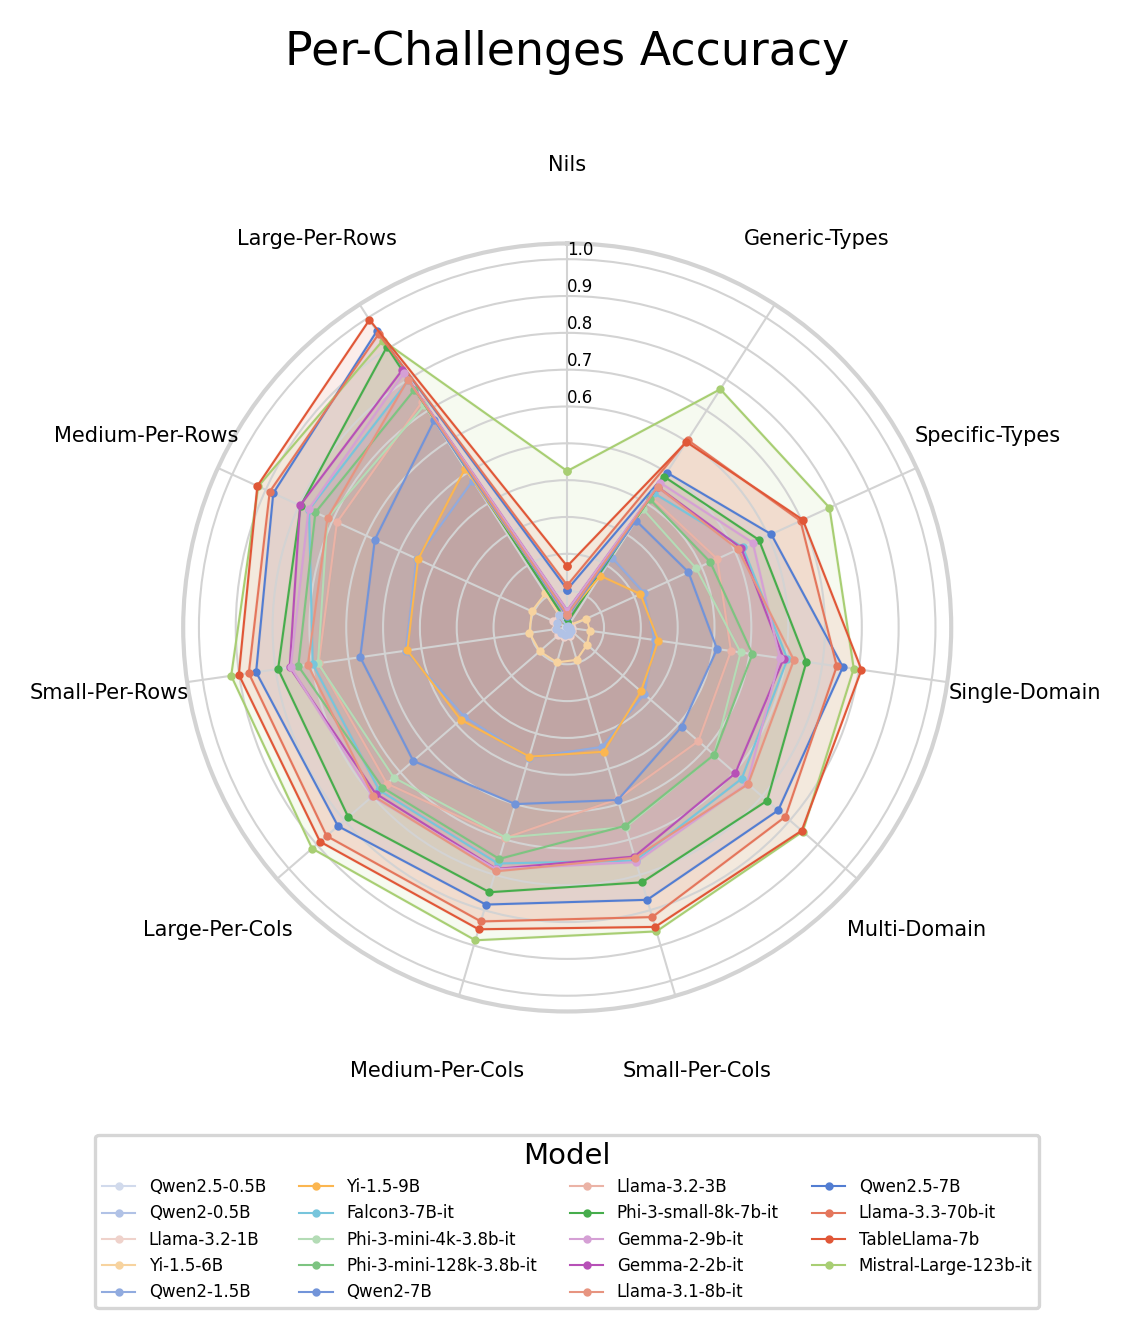

In [26]:
fig, ax = plt.subplots(figsize=(13, 5), subplot_kw={"projection": "polar"}, dpi=300)
title = ax.set_title("Per-Challenges Accuracy", y=1.2, fontsize=11)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlabel_position(90)
ax.spines["polar"].set_zorder(1)
ax.spines["polar"].set_color("lightgrey")
ax.grid(True, color="lightgrey", linewidth=0.5)

unique_models = per_challenge_results["model_name"].unique().tolist()
unique_challenges = per_challenge_results["challenge"].unique().tolist()
unique_challenges = [challenge for challenge in unique_challenges if challenge]

N = len(unique_challenges)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
theta = np.concatenate([theta, [theta[0]]])
for model_name in unique_models:
    values = (
        per_challenge_results[per_challenge_results["model_name"] == model_name][
            "accuracy"
        ]
        .sort_values()
        .tolist()
    )
    values = values + [values[0]]
    ax.plot(
        theta,
        values,
        marker="o",
        markersize=1,
        label=model_name,
        linewidth=0.5,
        color=palette[model_name],
    )
    ax.fill(theta, values, alpha=0.1, color=palette[model_name])
    ax.set_rlabel_position(0)  # Put radial tick labels at the top

plt.xticks(
    theta[:-1],
    [challenge.title().replace("_", "-") for challenge in unique_challenges],
    color="black",
    size=5,
)
plt.yticks(
    list(np.arange(0.1, 1.1, 0.1)),
    ["" if x <= 0.5 else f"{x:.1f}" for x in np.arange(0.1, 1.1, 0.1)],
    color="black",
    size=4,
    zorder=-1,
)
plt.tick_params(pad=7)

sorted_names = sorted(
    overall_results[["accuracy", "model_name"]].to_dict(orient="records"),
    key=lambda x: x["accuracy"],
    reverse=False,
)
handles, labels = ax.get_legend_handles_labels()
sorted_handles = []
sorted_labels = []
for name in sorted_names:
    for handle, label in zip(handles, labels):
        if name["model_name"] == label:
            sorted_handles.append(handle)
            sorted_labels.append(label)
            break
ax.legend(
    sorted_handles,
    sorted_labels,
    title="Model",
    fontsize=4,
    title_fontsize=7,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
)

plt.tight_layout()
plt.savefig(
    os.path.join(images_dir, "per_challenge_accuracy_spider.png"),
    bbox_inches="tight",
    dpi=300,
)

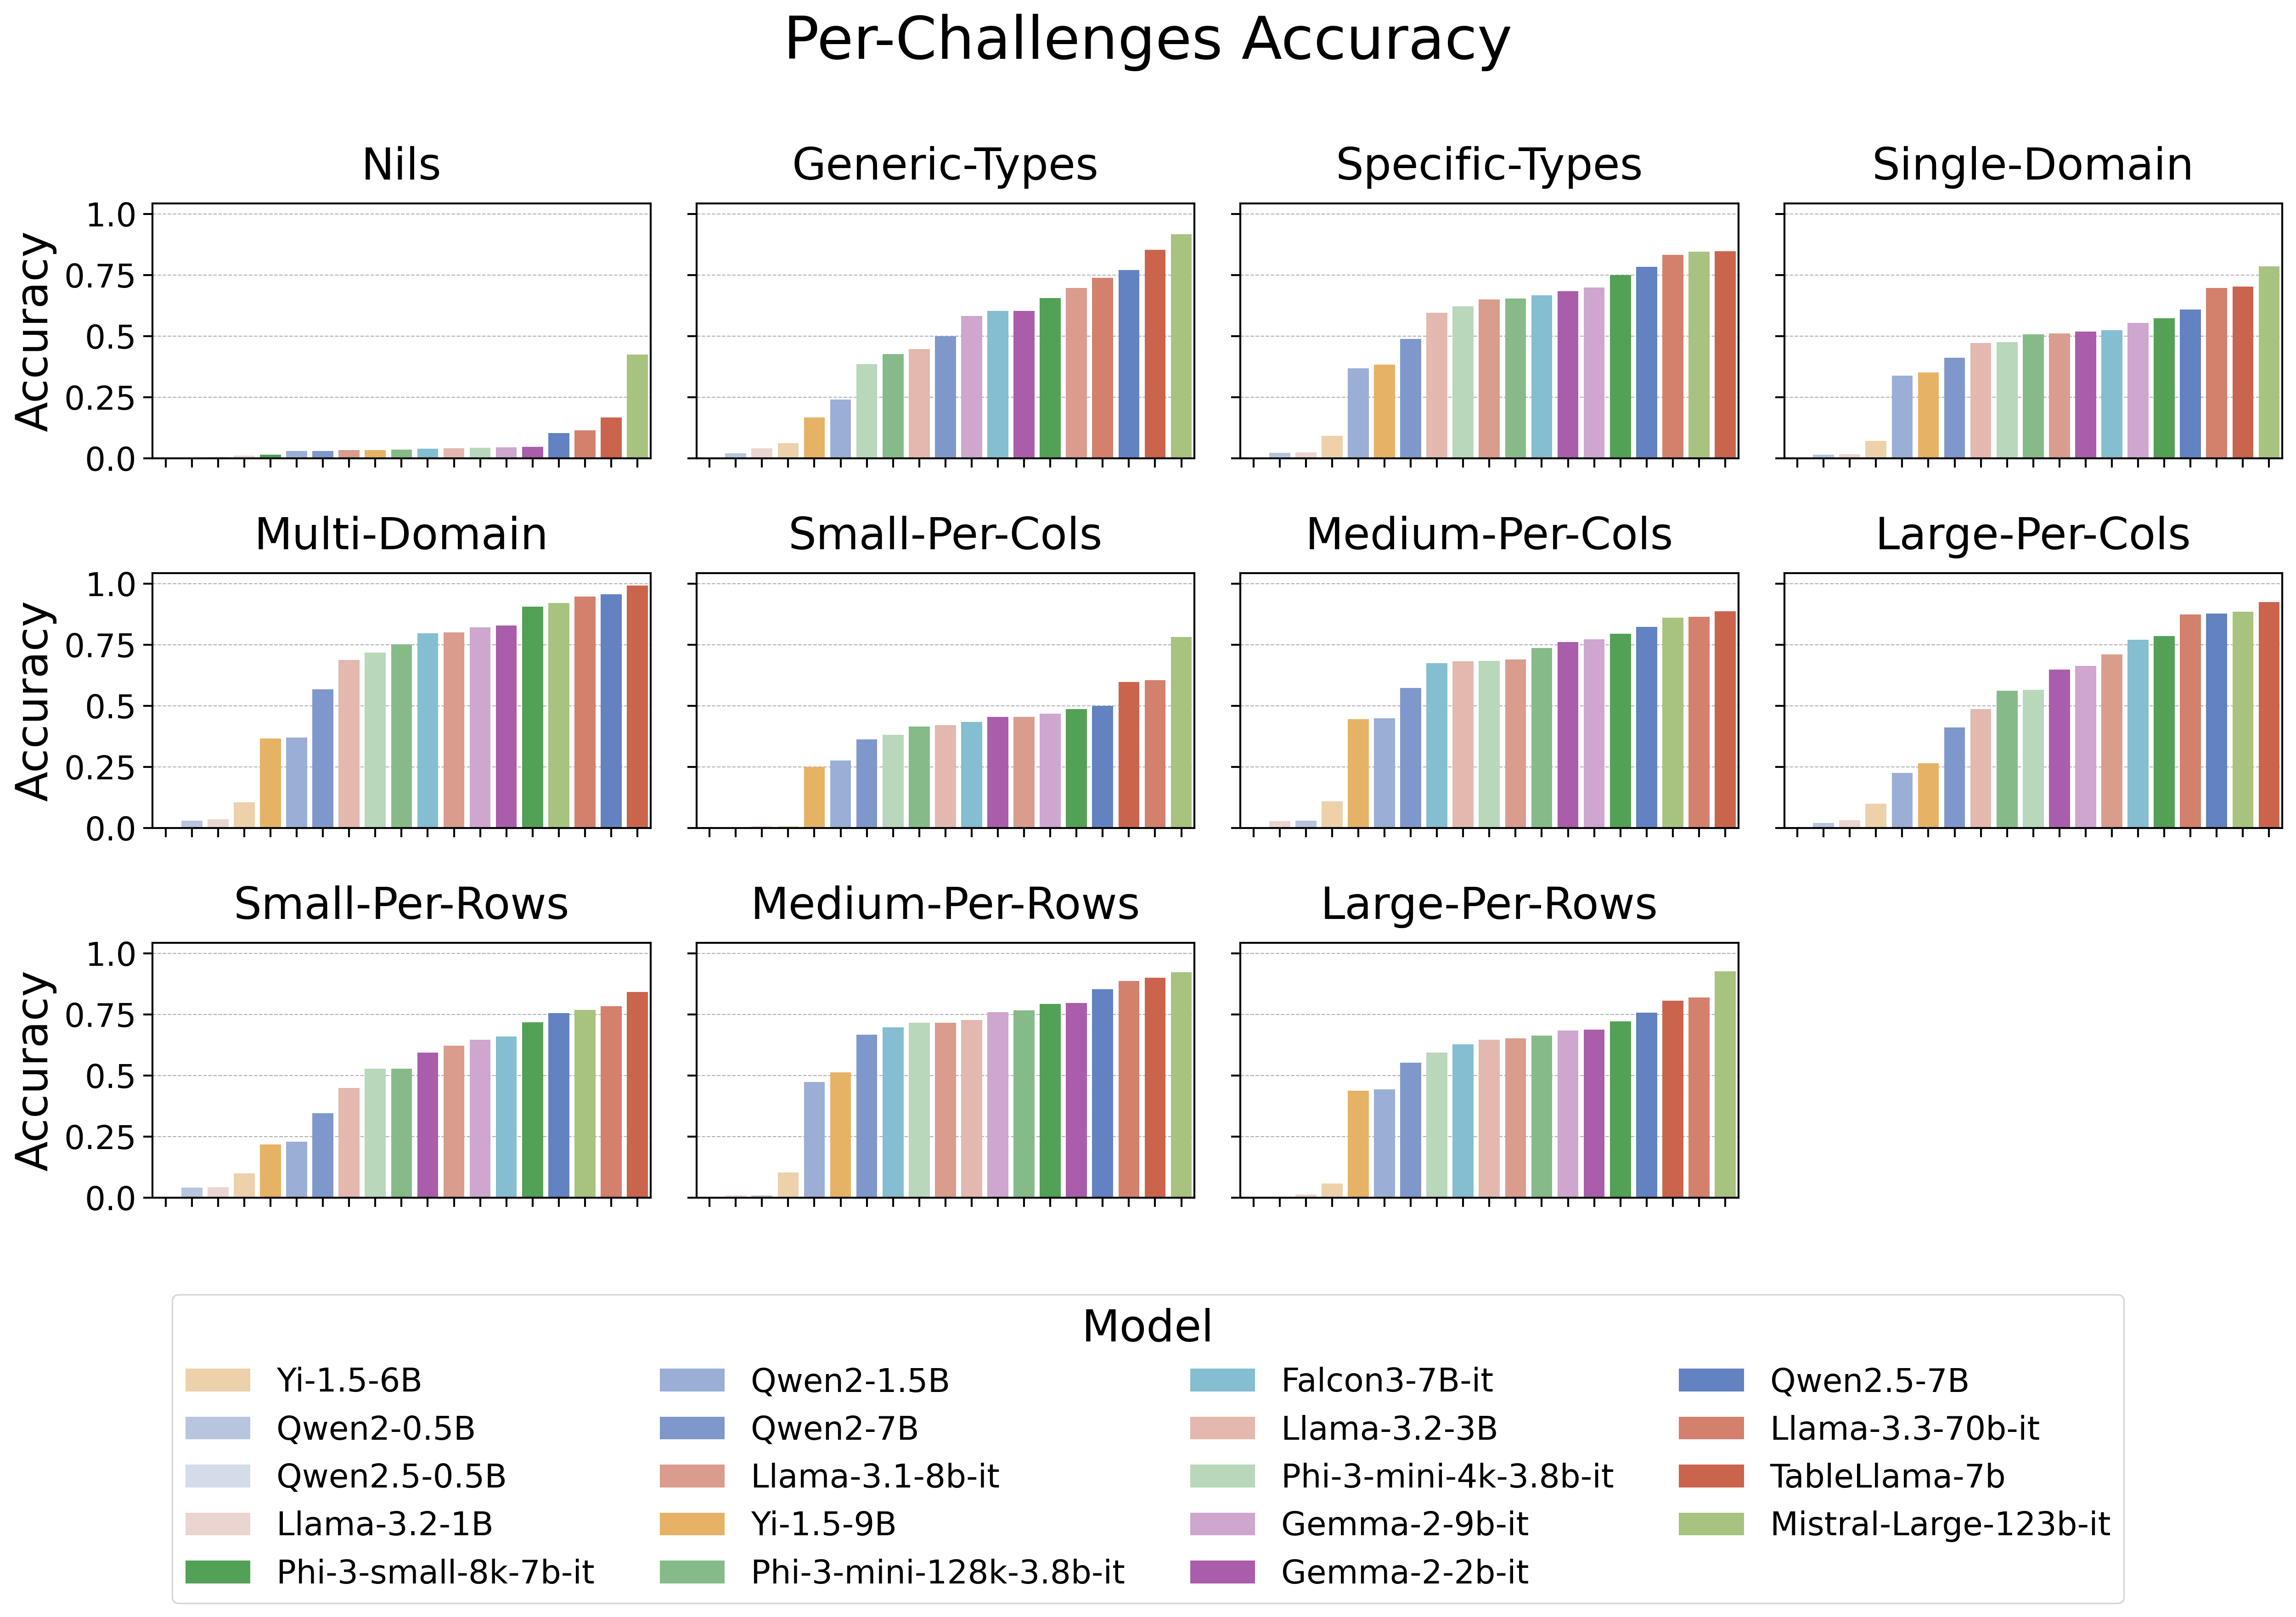

In [27]:
challenges = per_challenge_results["challenge"].unique().tolist()
challenges = [challenge for challenge in challenges]

nrows = 3
ncols = math.ceil(len(challenges) / nrows)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(17, 9), sharex=False, sharey=True, dpi=300
)
fig.suptitle(
    "Per-Challenges Accuracy",
    fontsize=31,
    y=1.0,
    ha="center",
)

# Handle both single row and multi-row cases
axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]

unique_model_names = per_challenge_results["model_name"].unique().tolist()
for i, challenge in enumerate(challenges):
    ax = axes_flat[i]
    ax.set_title(challenge.title().replace("_", "-"), y=1.05, fontsize=23)

    challenge_data = per_challenge_results[
        per_challenge_results["challenge"] == challenge
    ].sort_values(by="accuracy", ascending=True)

    if challenge_data.empty:
        continue

    # 2) plot, *no* hue, but *with* order=…
    sns.barplot(
        data=challenge_data,
        x="model_name",
        y="accuracy",
        palette=palette,
        hue="model_name",
        order=challenge_data["model_name"].tolist(),
        ax=ax,
        legend=True if i == 0 else False,
    )
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
    ax.set_xticklabels([])
    ax.set_xlabel("")
    ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(ax.get_yticks(), fontsize=17)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, which="major", linestyle="--", linewidth=0.5, zorder=99)
    if i % ncols == 0:
        ax.set_ylabel("Accuracy", fontsize=23)
    else:
        ax.set_ylabel("")

# Hide any empty subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis("off")

# Add legend to figure
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.02),
    ncol=4,
    title="Model",
    fontsize=17,
    title_fontsize=23,
)

plt.tight_layout(pad=2.0)
plt.savefig(
    os.path.join(images_dir, "per_challenge_accuracy.png"),
    bbox_inches="tight",
    dpi=300,
)